<a href="https://colab.research.google.com/github/dave502/computer_vision/blob/main/image%20generation%20with%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###GAN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

###класс GAN

In [ ]:
class GAN(keras.Model):

  def __init__(self, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = self.__discriminator()
    self.generator = self.__generator(latent_dim) 
    self.latent_dim = latent_dim

  def __discriminator(self):
    discriminator = keras.Sequential(
      [
          keras.Input(shape=(32, 32, 3)),
          layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(alpha=0.2),  
          layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(alpha=0.2),           
          layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.GlobalMaxPooling2D(),
          layers.Dense(1, activation='sigmoid'),
      ],
      name="discriminator",
    )
    return discriminator

  def __generator(self, latent_dim):
    generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 4x4x256 map
        layers.Dense(4 * 4 * 256),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 256)),
        # 8x8
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # 16x16
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # 32x32
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), padding="same", activation="tanh"),
    ],
    name="generator",
    )
    return generator

  def __repr__(self):
    print(self.discriminator.summary())
    print(self.generator.summary())

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
        real_images = real_images[0]
    # берем случайный пример из скрытого пространства
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Строим по нему фейковое изображение
    generated_images = self.generator(random_latent_vectors)

    # собрали с реальным в тензор
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # задаем метки 1 и 0 соответственно
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )
    # Добавляем шум !!!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # учим discriminator
    with tf.GradientTape() as tape:
        predictions = self.discriminator(combined_images)
        d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    #Выбрали случайный пример в скрытом пространстве
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # собрали метки реальных изображений
    misleading_labels = tf.zeros((batch_size, 1))

    # Учим generator !
    with tf.GradientTape() as tape:
        predictions = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    return {"d_loss": d_loss, "g_loss": g_loss}

  def fit(self, dataset, epochs):
     history = super(GAN, self).fit(
      dataset, epochs=epochs, callbacks=[self.GANMonitor(num_img=3, latent_dim=self.latent_dim)]
      )
     return history

  class GANMonitor(keras.callbacks.Callback):
    """
    Callback для сохранения изображений по ходу обучения
    """
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) / 2.0
        generated_images *= 255
        image = generated_images.numpy()
        image = image.astype(int)
        plt.figure(figsize = (self.num_img*4, 4))
        for i in range(self.num_img):
          plt.subplot(1,self.num_img,i+1)
          plt.imshow(image[i])
        plt.show()
        #for i in range(self.num_img):
        #    img = keras.preprocessing.image.array_to_img(generated_images[i])
        #    img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))  


### Обучение и генерация

In [ ]:
# загрузка cifar10 
class_ = 3
batch_size = 64
(x_train, y), (x_test, yt) = keras.datasets.cifar10.load_data()
all_img = np.concatenate([x_train, x_test])
all_img = all_img.astype("float32") / 255
ind_i = np.where(y == class_)
ind_it = np.where(yt == class_)
all_img = all_img[ind_i,:,:]
all_img = np.reshape(all_img, (-1, 32, 32, 3))
dataset = tf.data.Dataset.from_tensor_slices(all_img)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

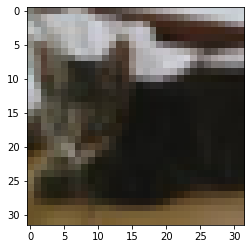

In [ ]:
plt.imshow(all_img[0])
plt.show()

In [ ]:
model = GAN(128)
model.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.5578 - g_loss: 1.4149

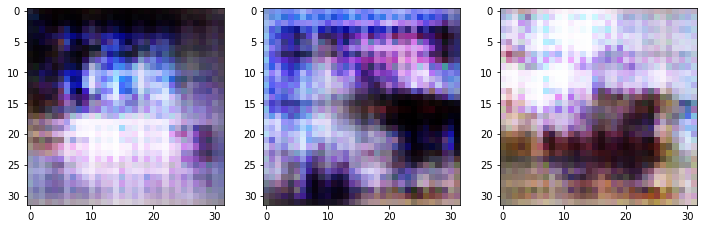

1563/1563 [==============================] - 34s 21ms/step - d_loss: 0.5581 - g_loss: 1.4146
Epoch 2/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.6283 - g_loss: 1.0547

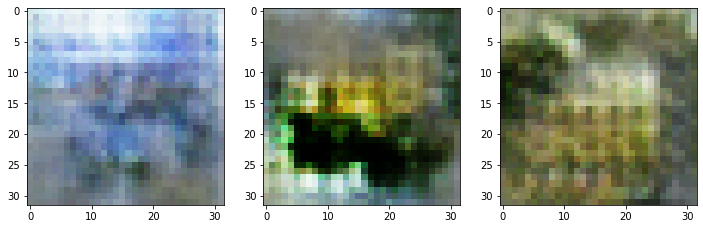

1563/1563 [==============================] - 33s 21ms/step - d_loss: 0.6283 - g_loss: 1.0547
Epoch 3/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.6246 - g_loss: 1.0480

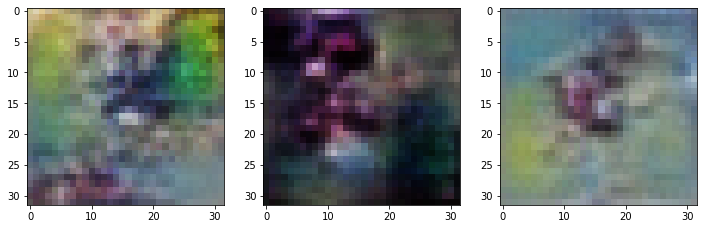

1563/1563 [==============================] - 34s 22ms/step - d_loss: 0.6248 - g_loss: 1.0483
Epoch 4/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.6328 - g_loss: 0.9770

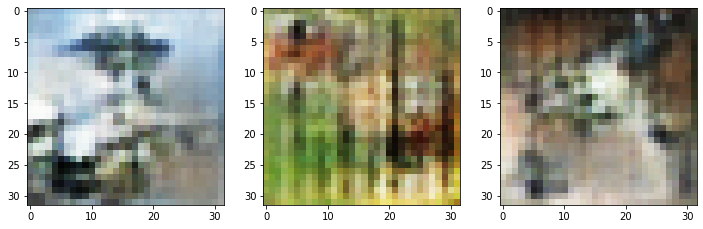

1563/1563 [==============================] - 34s 22ms/step - d_loss: 0.6329 - g_loss: 0.9769
Epoch 5/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.6524 - g_loss: 0.9025

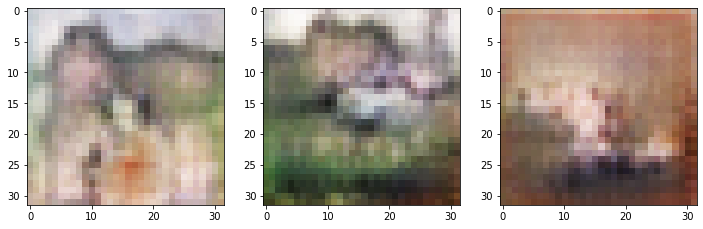

1563/1563 [==============================] - 34s 22ms/step - d_loss: 0.6524 - g_loss: 0.9024
Epoch 6/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.6502 - g_loss: 0.9035

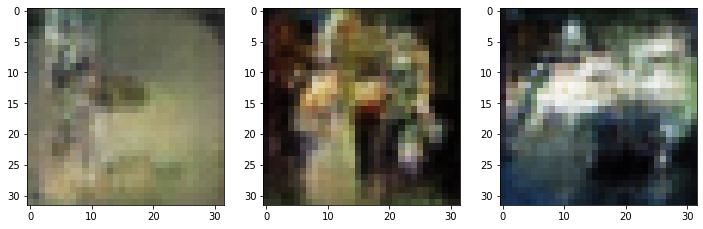

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.6502 - g_loss: 0.9032
Epoch 7/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.6486 - g_loss: 0.8983

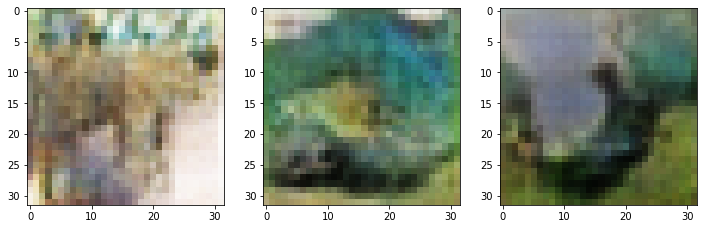

1563/1563 [==============================] - 35s 22ms/step - d_loss: 0.6486 - g_loss: 0.8982
Epoch 8/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.6406 - g_loss: 0.9122

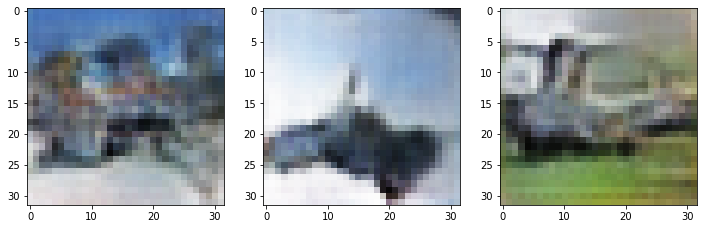

1563/1563 [==============================] - 35s 22ms/step - d_loss: 0.6406 - g_loss: 0.9120
Epoch 9/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.6346 - g_loss: 0.9251

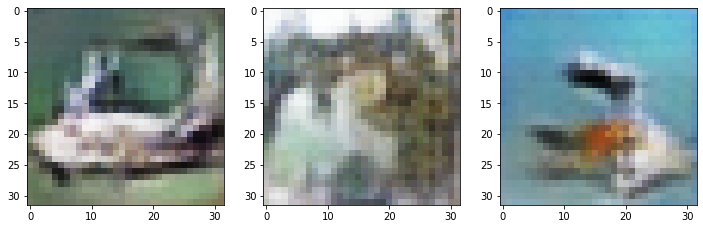

1563/1563 [==============================] - 35s 22ms/step - d_loss: 0.6346 - g_loss: 0.9251
Epoch 10/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.6317 - g_loss: 0.9330

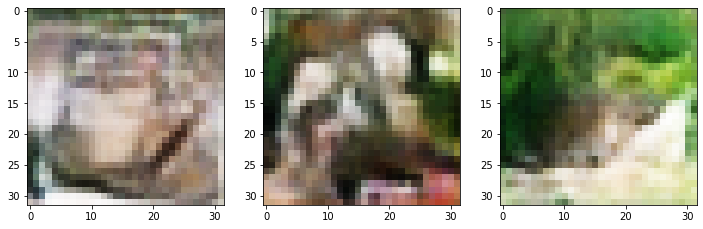

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.6317 - g_loss: 0.9330
Epoch 11/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.6259 - g_loss: 0.9445

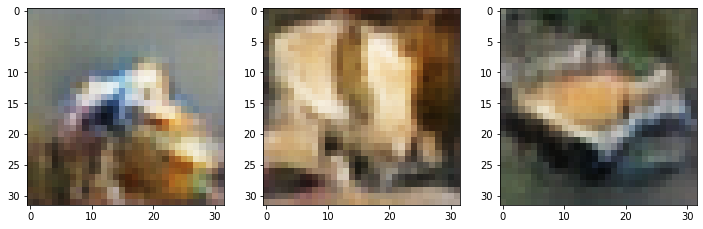

1563/1563 [==============================] - 35s 22ms/step - d_loss: 0.6260 - g_loss: 0.9445
Epoch 12/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.6145 - g_loss: 0.9681

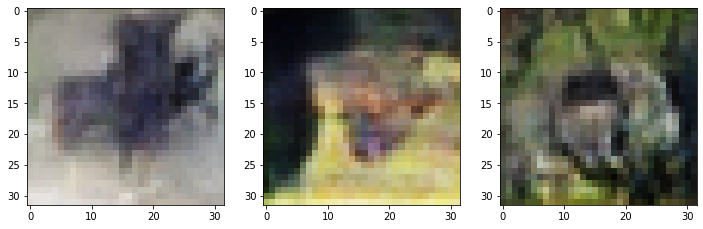

1563/1563 [==============================] - 35s 22ms/step - d_loss: 0.6145 - g_loss: 0.9681
Epoch 13/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.6040 - g_loss: 1.0089

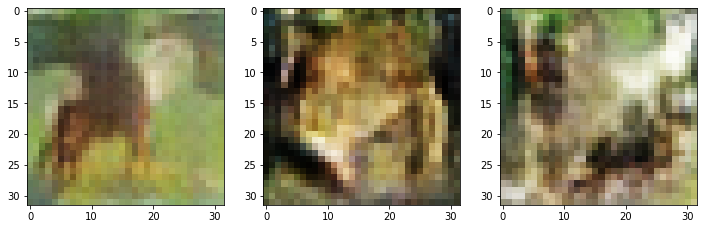

1563/1563 [==============================] - 35s 22ms/step - d_loss: 0.6039 - g_loss: 1.0090
Epoch 14/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.5921 - g_loss: 1.0373

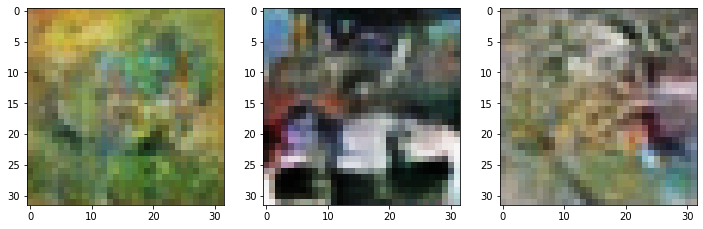

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.5921 - g_loss: 1.0372
Epoch 15/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.5858 - g_loss: 1.0619

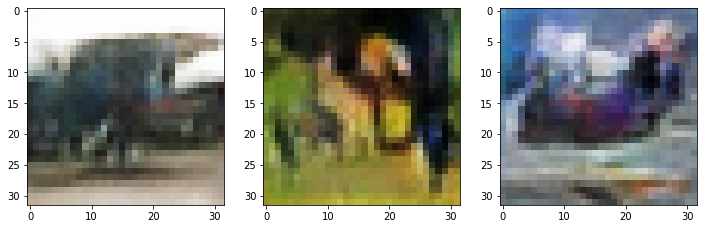

1563/1563 [==============================] - 35s 22ms/step - d_loss: 0.5857 - g_loss: 1.0617
Epoch 16/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.5777 - g_loss: 1.0803

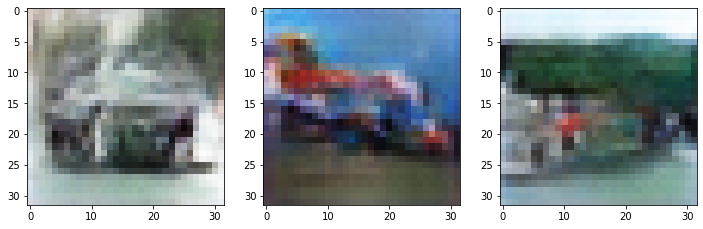

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.5776 - g_loss: 1.0801
Epoch 17/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.5686 - g_loss: 1.1130

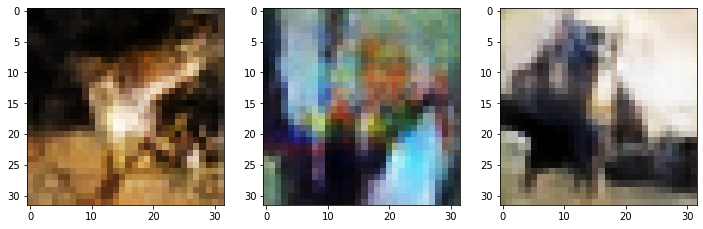

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.5686 - g_loss: 1.1130
Epoch 18/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.5597 - g_loss: 1.1390

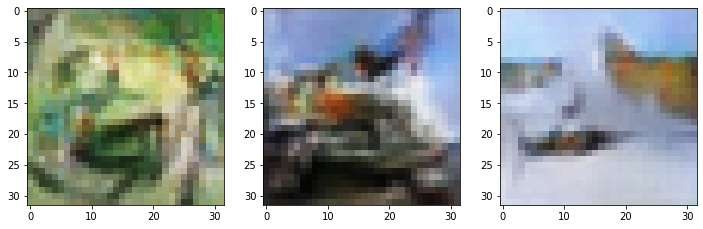

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.5598 - g_loss: 1.1389
Epoch 19/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.5544 - g_loss: 1.1668

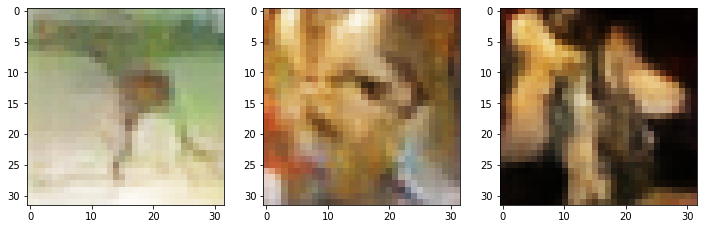

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.5544 - g_loss: 1.1665
Epoch 20/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.5437 - g_loss: 1.1985

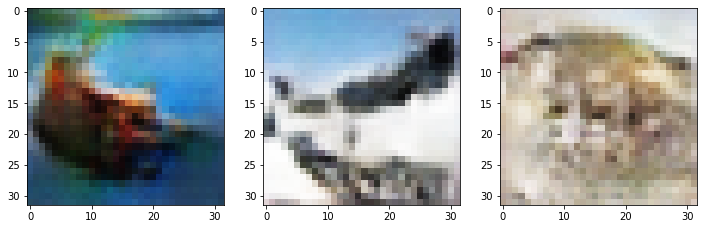

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.5436 - g_loss: 1.1985
Epoch 21/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.5336 - g_loss: 1.2279

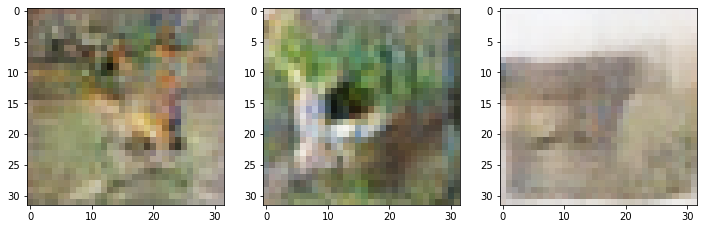

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.5336 - g_loss: 1.2275
Epoch 22/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.5255 - g_loss: 1.2596

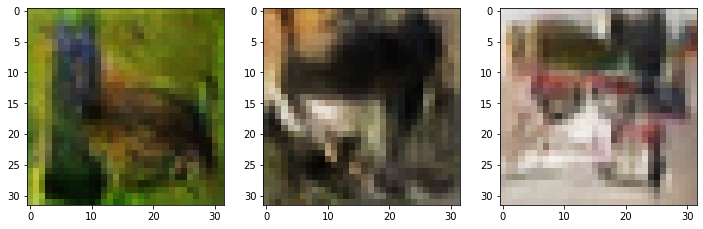

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.5254 - g_loss: 1.2596
Epoch 23/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.5191 - g_loss: 1.2900

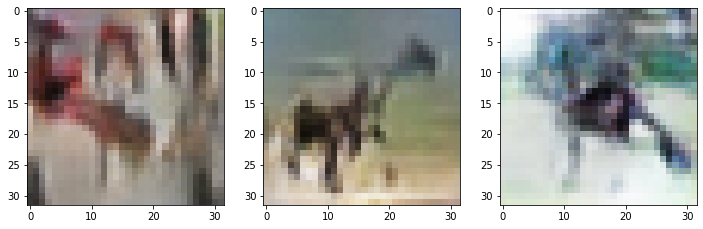

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.5192 - g_loss: 1.2898
Epoch 24/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.5106 - g_loss: 1.3247

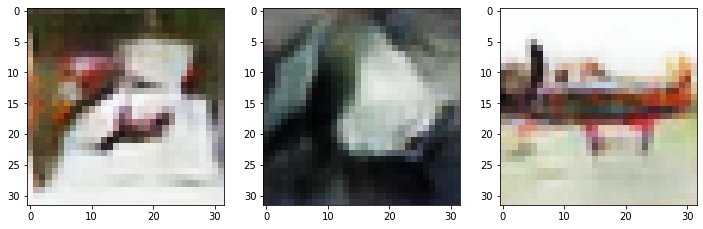

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.5105 - g_loss: 1.3249
Epoch 25/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.5007 - g_loss: 1.3636

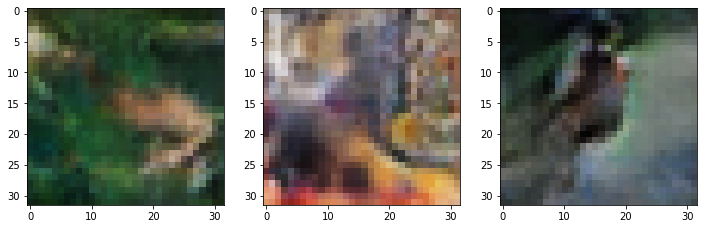

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.5007 - g_loss: 1.3638
Epoch 26/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.4916 - g_loss: 1.4031

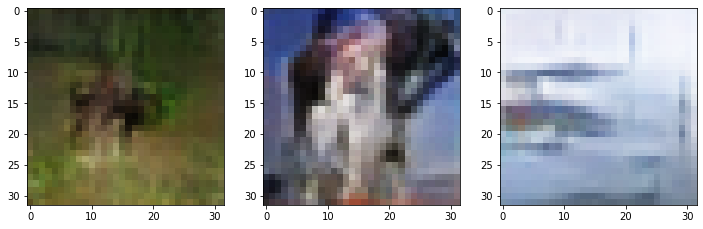

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4917 - g_loss: 1.4030
Epoch 27/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.4852 - g_loss: 1.4407

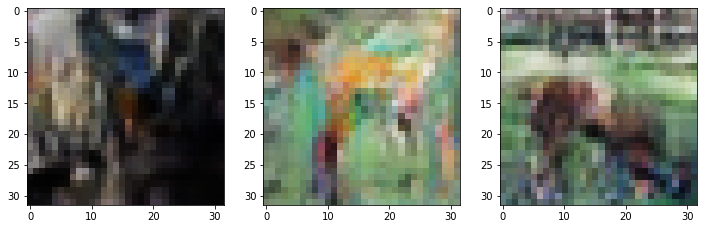

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4852 - g_loss: 1.4406
Epoch 28/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.4740 - g_loss: 1.4856

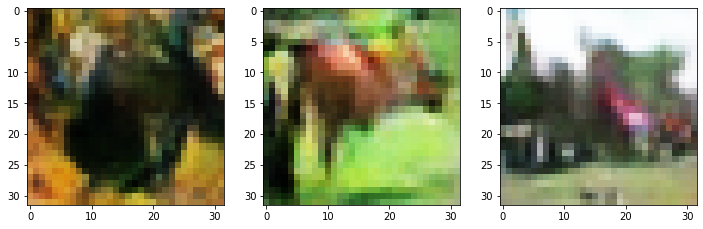

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4741 - g_loss: 1.4853
Epoch 29/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.4638 - g_loss: 1.5335

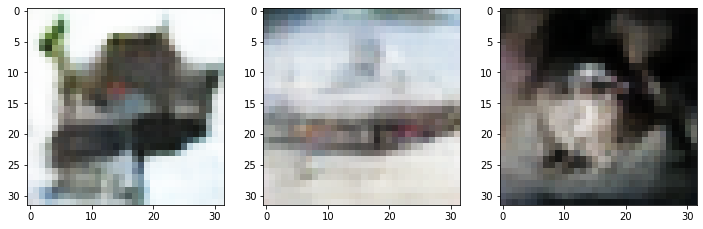

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4641 - g_loss: 1.5334
Epoch 30/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.4581 - g_loss: 1.5659

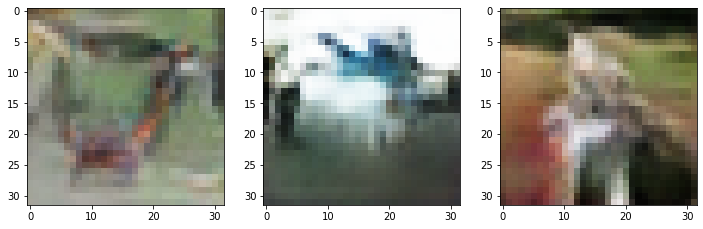

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4581 - g_loss: 1.5658
Epoch 31/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.4478 - g_loss: 1.6076

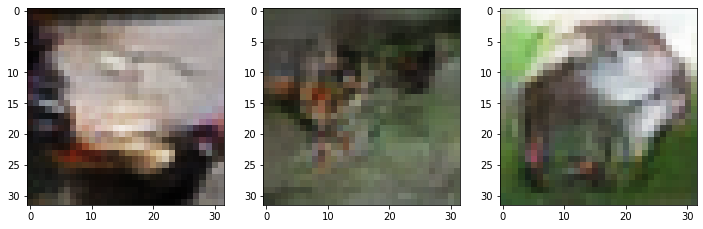

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4478 - g_loss: 1.6078
Epoch 32/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.4394 - g_loss: 1.6506

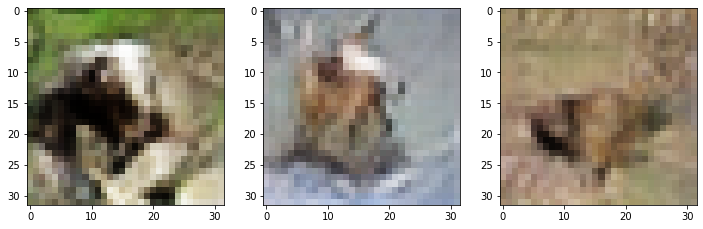

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4394 - g_loss: 1.6505
Epoch 33/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.4299 - g_loss: 1.6905

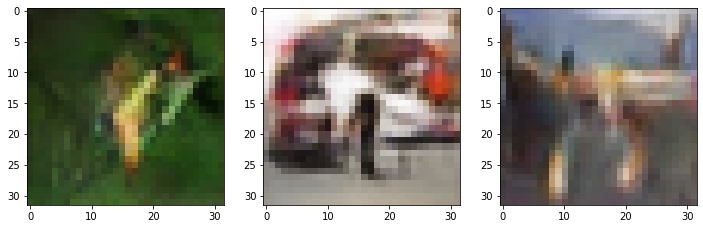

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4300 - g_loss: 1.6914
Epoch 34/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.4199 - g_loss: 1.7536

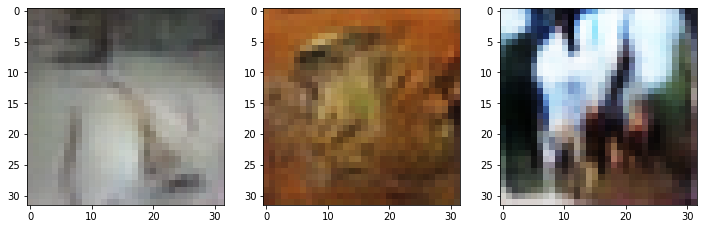

1563/1563 [==============================] - 35s 23ms/step - d_loss: 0.4199 - g_loss: 1.7529
Epoch 35/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.4111 - g_loss: 1.8075

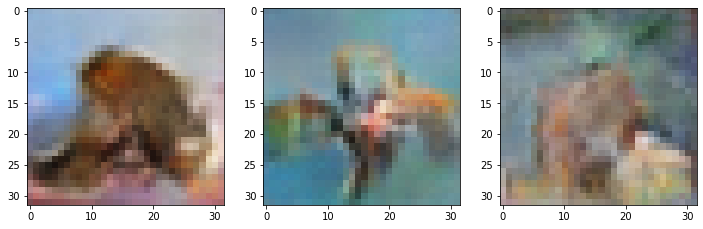

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4111 - g_loss: 1.8075
Epoch 36/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.4042 - g_loss: 1.8405

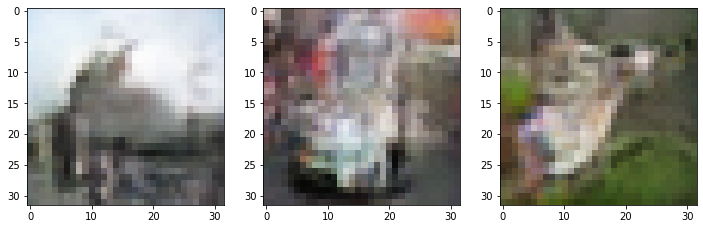

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.4041 - g_loss: 1.8402
Epoch 37/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3996 - g_loss: 1.8848

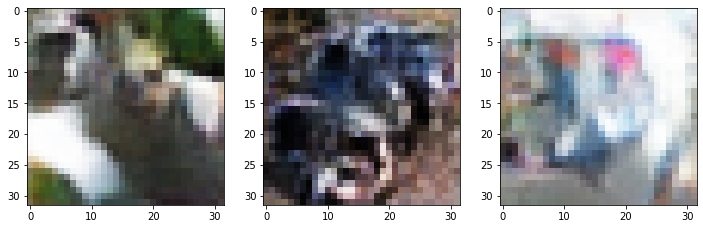

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.3995 - g_loss: 1.8846
Epoch 38/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.3912 - g_loss: 1.9392

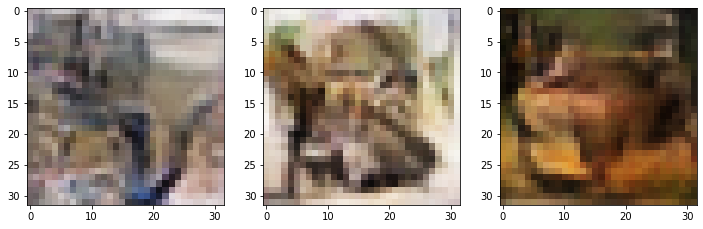

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.3913 - g_loss: 1.9388
Epoch 39/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.3792 - g_loss: 2.0053

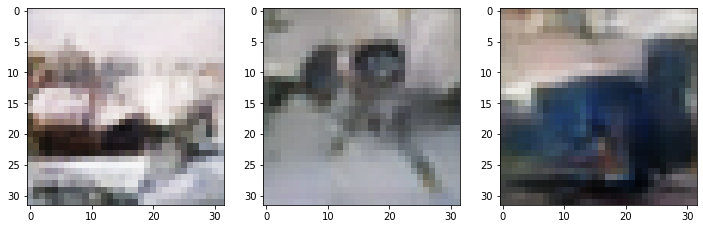

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.3791 - g_loss: 2.0055
Epoch 40/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3711 - g_loss: 2.0493

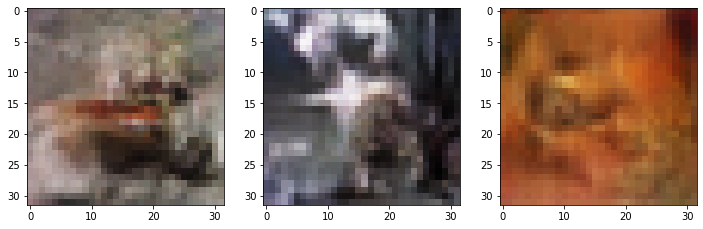

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.3710 - g_loss: 2.0498
Epoch 41/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3688 - g_loss: 2.0903

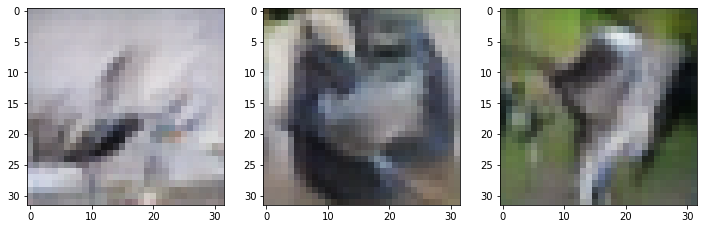

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.3690 - g_loss: 2.0899
Epoch 42/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.3612 - g_loss: 2.1514

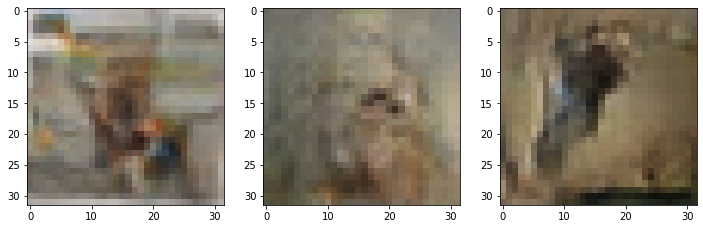

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.3613 - g_loss: 2.1508
Epoch 43/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3521 - g_loss: 2.2005

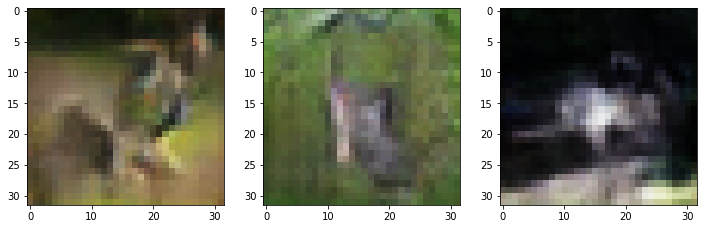

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.3519 - g_loss: 2.2002
Epoch 44/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3482 - g_loss: 2.2524

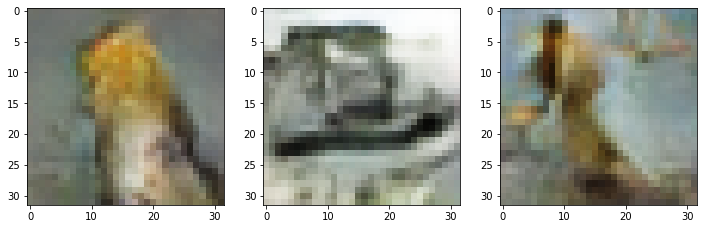

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.3482 - g_loss: 2.2523
Epoch 45/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3401 - g_loss: 2.3075

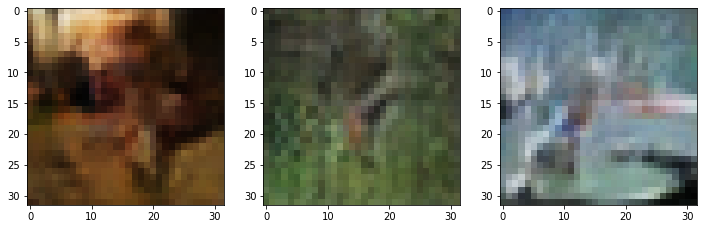

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.3401 - g_loss: 2.3074
Epoch 46/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3328 - g_loss: 2.3510

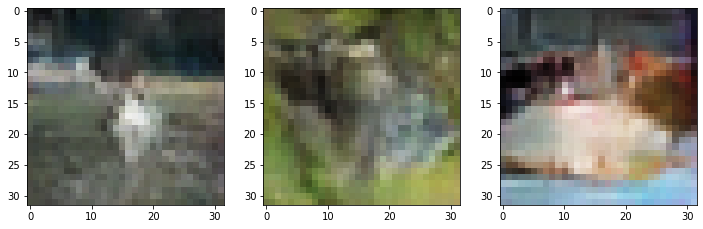

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.3326 - g_loss: 2.3508
Epoch 47/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.3262 - g_loss: 2.4307

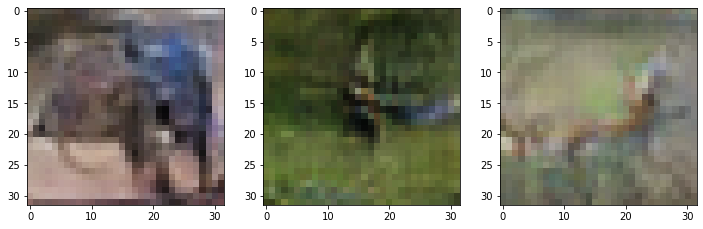

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.3262 - g_loss: 2.4311
Epoch 48/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.3191 - g_loss: 2.4686

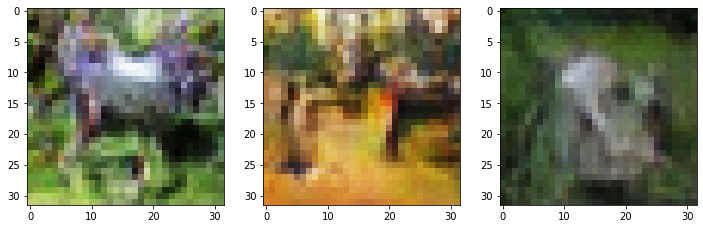

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.3193 - g_loss: 2.4688
Epoch 49/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3116 - g_loss: 2.5501

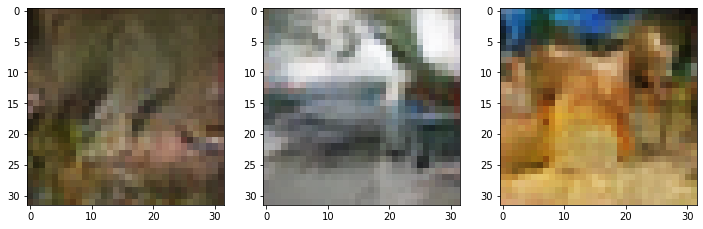

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.3118 - g_loss: 2.5501
Epoch 50/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.3065 - g_loss: 2.5843

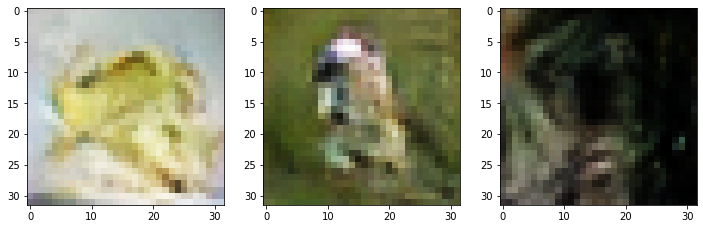

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.3065 - g_loss: 2.5848
Epoch 51/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3057 - g_loss: 2.6531

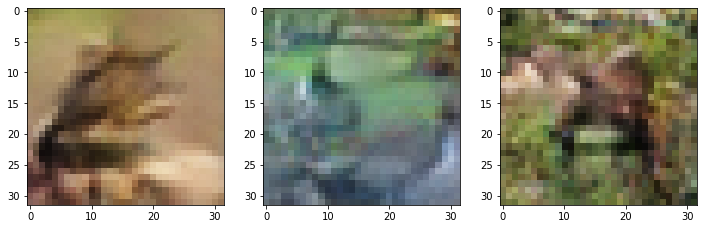

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.3057 - g_loss: 2.6525
Epoch 52/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.3002 - g_loss: 2.6849

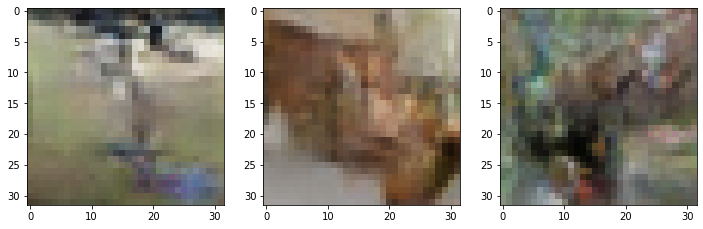

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.3001 - g_loss: 2.6850
Epoch 53/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2940 - g_loss: 2.7363

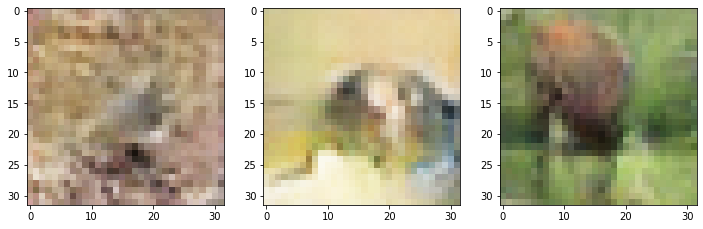

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.2941 - g_loss: 2.7366
Epoch 54/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2876 - g_loss: 2.8048

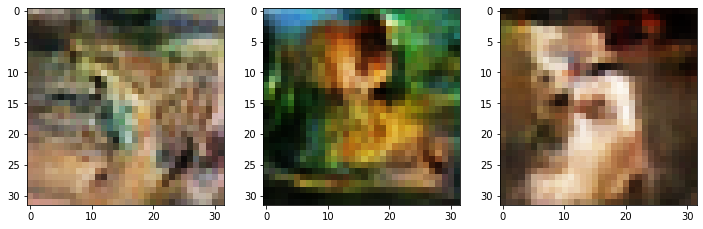

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.2875 - g_loss: 2.8041
Epoch 55/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2843 - g_loss: 2.8523

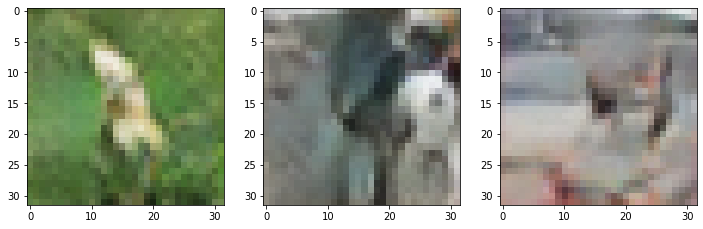

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2843 - g_loss: 2.8516
Epoch 56/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2753 - g_loss: 2.9133

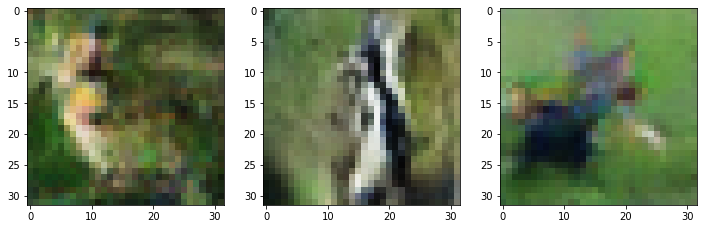

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2752 - g_loss: 2.9128
Epoch 57/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.2744 - g_loss: 2.9711

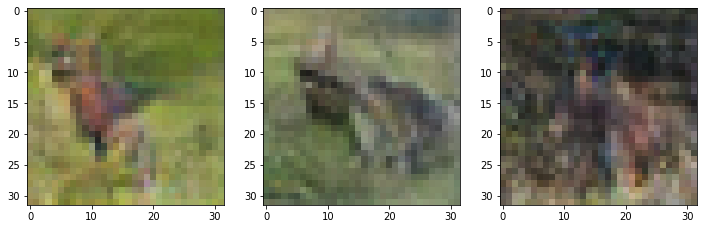

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2744 - g_loss: 2.9708
Epoch 58/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2703 - g_loss: 3.0257

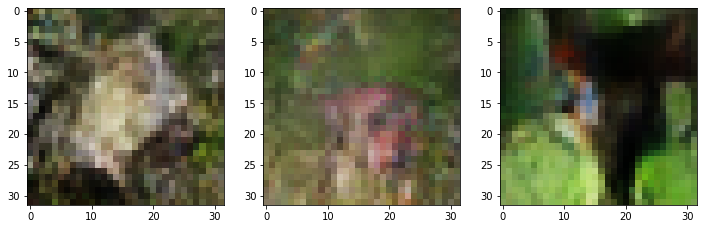

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2702 - g_loss: 3.0247
Epoch 59/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2657 - g_loss: 3.0957

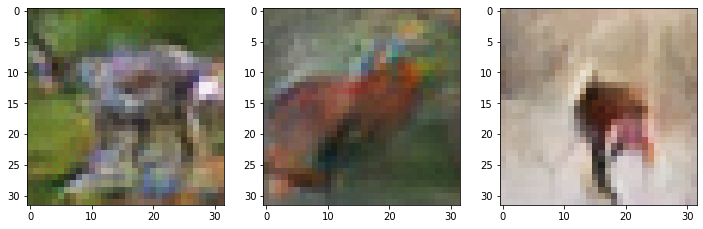

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2657 - g_loss: 3.0955
Epoch 60/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2631 - g_loss: 3.1451

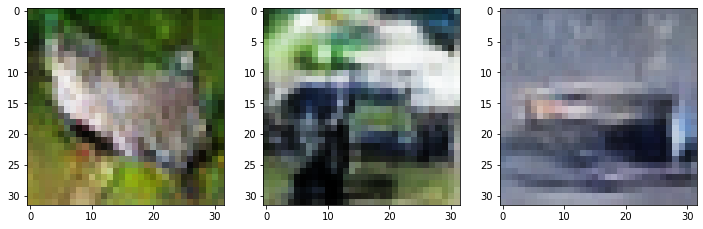

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.2632 - g_loss: 3.1450
Epoch 61/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.2559 - g_loss: 3.2092

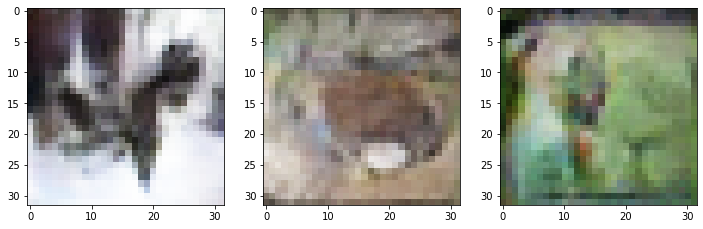

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2559 - g_loss: 3.2088
Epoch 62/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.2558 - g_loss: 3.2436

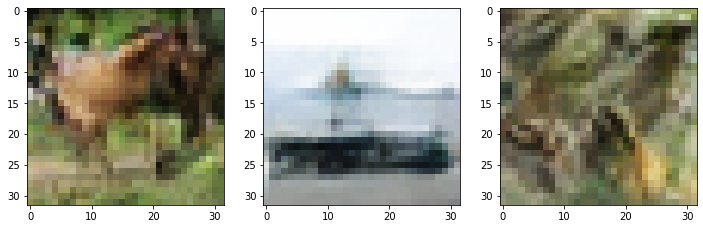

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.2560 - g_loss: 3.2437
Epoch 63/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2479 - g_loss: 3.3236

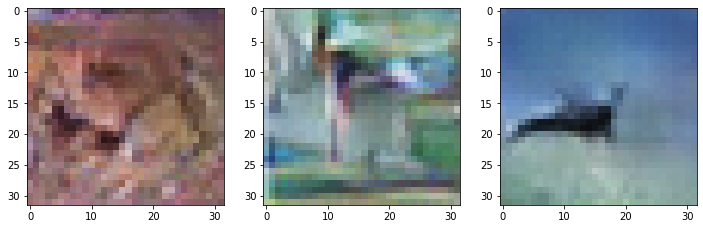

1563/1563 [==============================] - 38s 24ms/step - d_loss: 0.2479 - g_loss: 3.3233
Epoch 64/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.2486 - g_loss: 3.3755

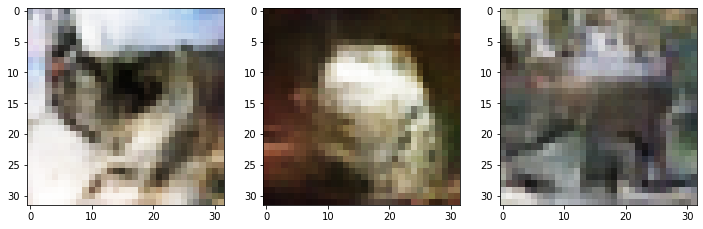

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2488 - g_loss: 3.3749
Epoch 65/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.2450 - g_loss: 3.4351

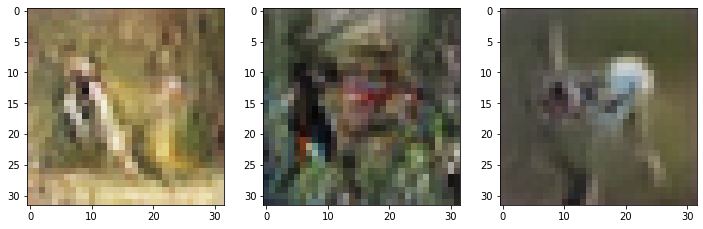

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.2450 - g_loss: 3.4349
Epoch 66/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.2361 - g_loss: 3.5101

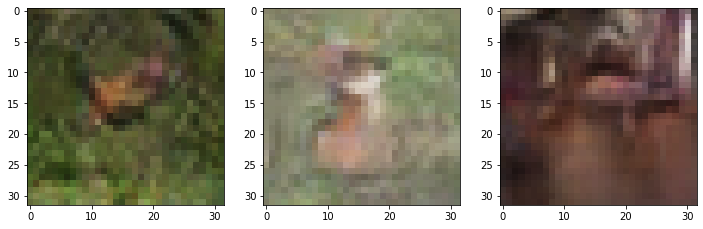

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2360 - g_loss: 3.5103
Epoch 67/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.2309 - g_loss: 3.5699

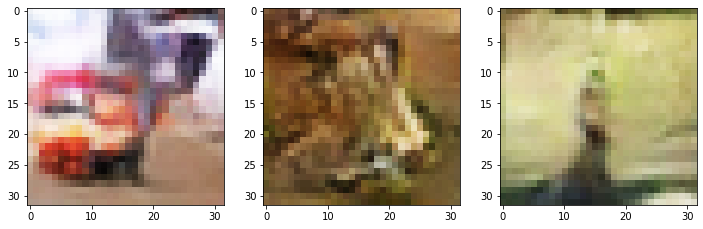

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2309 - g_loss: 3.5691
Epoch 68/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.2320 - g_loss: 3.6309

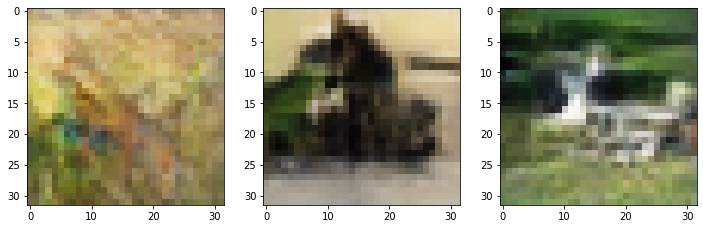

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2321 - g_loss: 3.6307
Epoch 69/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.2242 - g_loss: 3.6922

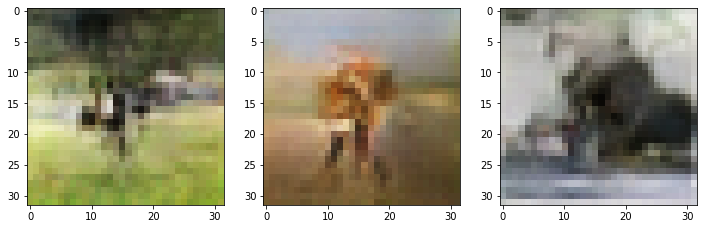

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2243 - g_loss: 3.6925
Epoch 70/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2256 - g_loss: 3.7542

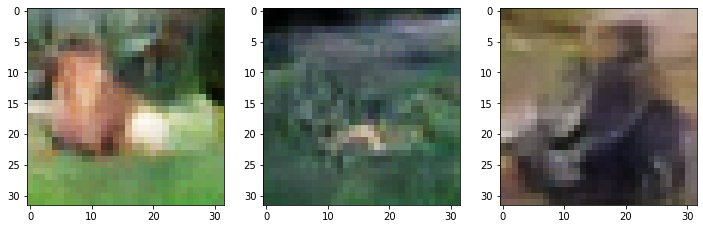

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2256 - g_loss: 3.7538
Epoch 71/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2186 - g_loss: 3.8107

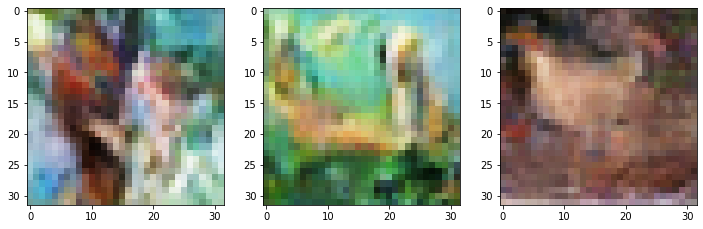

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2185 - g_loss: 3.8120
Epoch 72/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2209 - g_loss: 3.8573

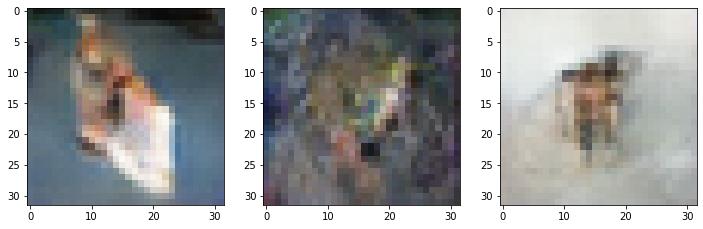

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2207 - g_loss: 3.8567
Epoch 73/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2208 - g_loss: 3.8991

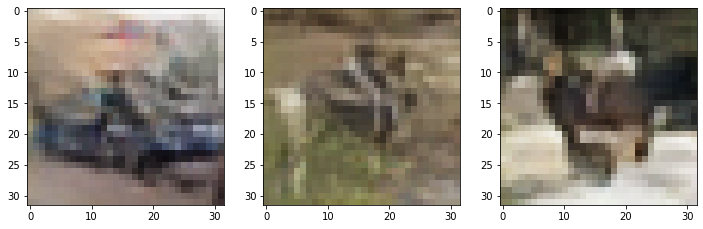

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2206 - g_loss: 3.8995
Epoch 74/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2145 - g_loss: 3.9787

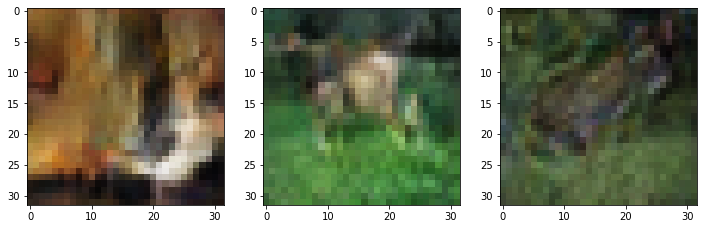

1563/1563 [==============================] - 38s 24ms/step - d_loss: 0.2144 - g_loss: 3.9787
Epoch 75/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2131 - g_loss: 4.0331

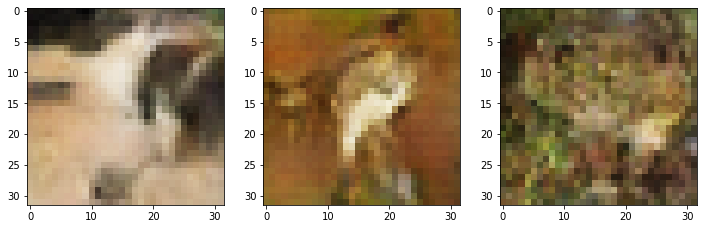

1563/1563 [==============================] - 38s 24ms/step - d_loss: 0.2130 - g_loss: 4.0331
Epoch 76/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2114 - g_loss: 4.1117

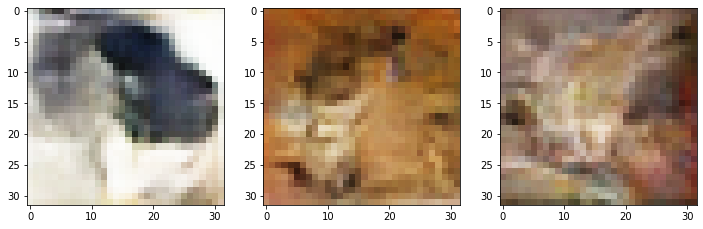

1563/1563 [==============================] - 38s 24ms/step - d_loss: 0.2114 - g_loss: 4.1114
Epoch 77/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2066 - g_loss: 4.1599

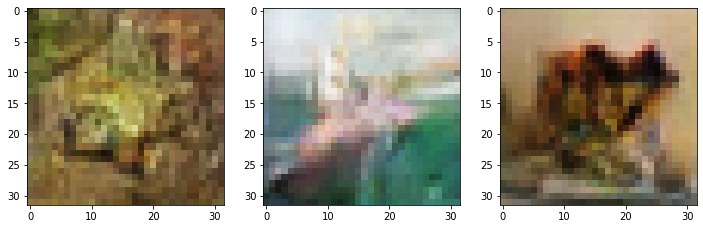

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2065 - g_loss: 4.1586
Epoch 78/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2066 - g_loss: 4.2136

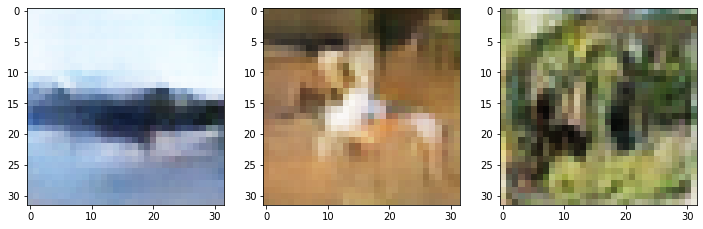

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2064 - g_loss: 4.2131
Epoch 79/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2055 - g_loss: 4.2491

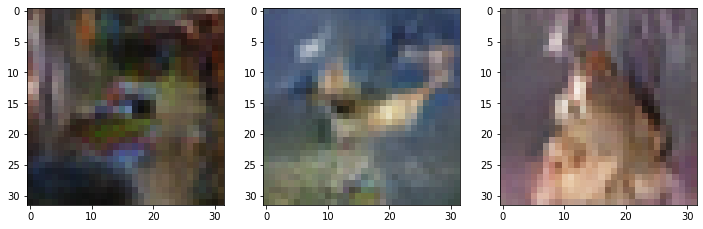

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2053 - g_loss: 4.2491
Epoch 80/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.1995 - g_loss: 4.3115

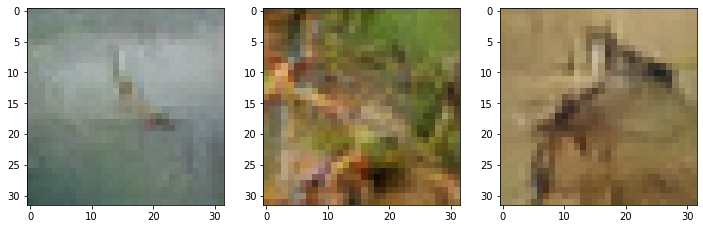

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.1995 - g_loss: 4.3103
Epoch 81/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.2012 - g_loss: 4.3703

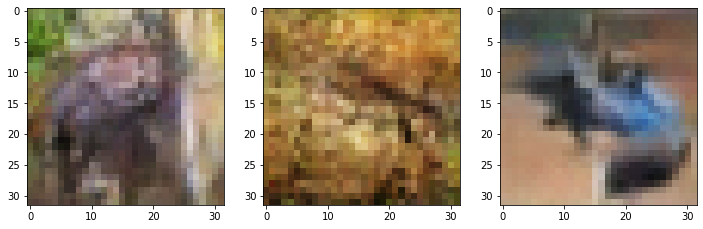

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.2015 - g_loss: 4.3691
Epoch 82/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.1970 - g_loss: 4.4089

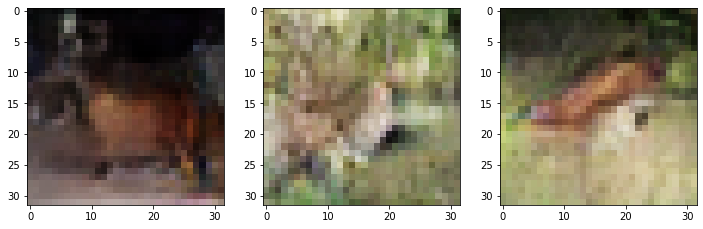

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.1970 - g_loss: 4.4083
Epoch 83/90
1561/1563 [============================>.] - ETA: 0s - d_loss: 0.2005 - g_loss: 4.4898

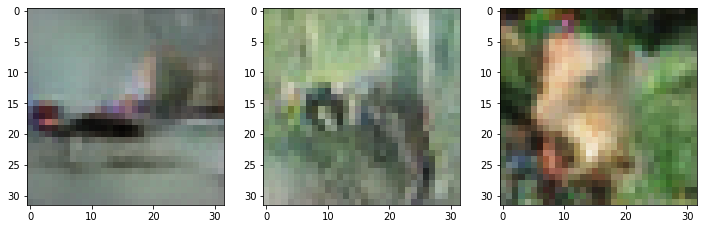

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.2010 - g_loss: 4.4874
Epoch 84/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.1954 - g_loss: 4.5279

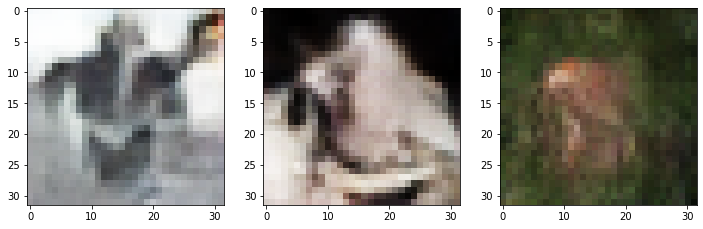

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.1954 - g_loss: 4.5287
Epoch 85/90
1563/1563 [==============================] - ETA: 0s - d_loss: 0.1988 - g_loss: 4.5737

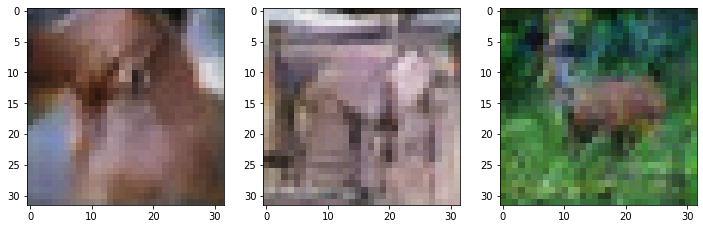

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.1988 - g_loss: 4.5733
Epoch 86/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.1947 - g_loss: 4.5829

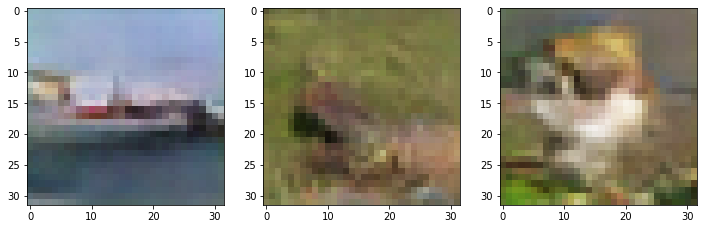

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.1948 - g_loss: 4.5815
Epoch 87/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.1876 - g_loss: 4.6883

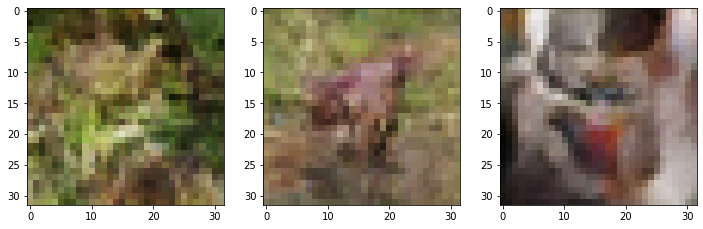

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.1877 - g_loss: 4.6879
Epoch 88/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.1923 - g_loss: 4.7050

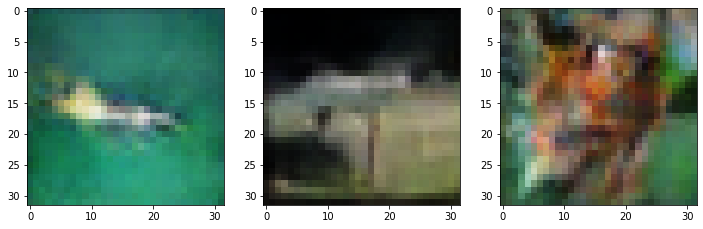

1563/1563 [==============================] - 36s 23ms/step - d_loss: 0.1922 - g_loss: 4.7037
Epoch 89/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.1870 - g_loss: 4.7707

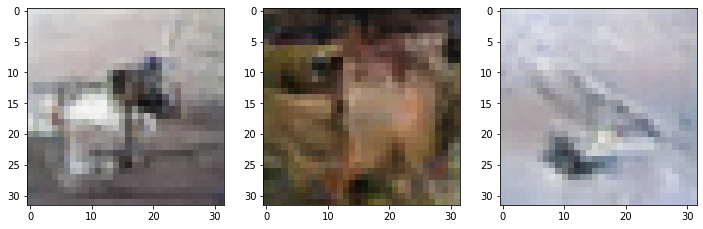

1563/1563 [==============================] - 37s 24ms/step - d_loss: 0.1870 - g_loss: 4.7699
Epoch 90/90
1562/1563 [============================>.] - ETA: 0s - d_loss: 0.1807 - g_loss: 4.8240

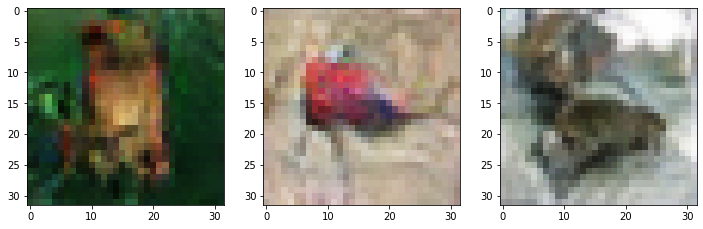

1563/1563 [==============================] - 37s 23ms/step - d_loss: 0.1807 - g_loss: 4.8237


In [ ]:
epochs = 90
history = model.fit(dataset, epochs=epochs)

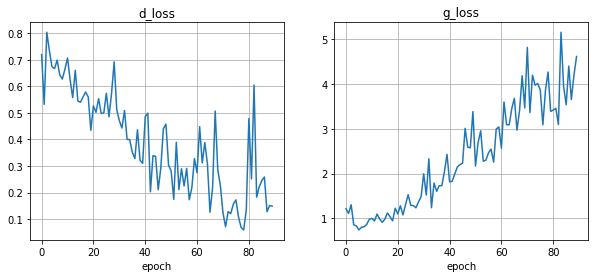

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(history.history['d_loss'])
plt.title('d_loss')
plt.xlabel('epoch')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(history.history['g_loss'])
plt.title('g_loss')
plt.xlabel('epoch')
plt.grid(True)
2

plt.show()

In [ ]:
I = model.generator(tf.random.normal(shape=(1, model.latent_dim)))

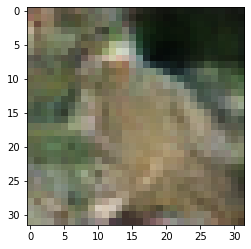

In [ ]:
plt.imshow((I[0]+1)/2)
plt.show()

На картинке невозможно распознать какой-либо объект, возможно при большем количестве эпох результат был бы лучше. Но 90 эпох обучения заняли около часа времени.